<a href="https://colab.research.google.com/github/jcs-lambda/DS-Unit-2-Applied-Modeling/blob/master/module4/LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install -U --quiet category_encoders eli5 pdpbox shap pandas-profiling

# If you're working locally:
else:
    DATA_PATH = '../data/'

# My work

## Previous work

In [0]:
import sys

if 'google.colab' in sys.modules:
  dhs_foia_fy2018_data = 'https://github.com/jcs-lambda/DS-Unit-2-Applied-Modeling/blob/master/data/dhs_foia_fy2018.csv?raw=true'
  !pip install -U --quiet pandas-profiling category_encoders eli5
else:
  dhs_foia_fy2018_data = '../data/dhs_foia_fy2018.csv'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(dhs_foia_fy2018_data)
print('Shape:', df.shape)

Shape: (125143, 13)


In [0]:
random_state = 13

In [0]:
agencies = {
    'CISA':'Cybersecurity and Infrastructure Security Agency',
    'FEMA':'Federal Emergency Management Agency',
    'FLETC':'Federal Law Enforcement Training Centers',
    'I&A':'Office of Intelligence and Analysis',
    'ICE':'U.S. Immigration and Customs Enforcement',
    'OIG':'Office of Inspector General',
    'PRIV':'Privacy Office',
    'S&T':'Science and Technology Directorate',
    'TSA':'Transportation Security Administration',
    'USCG':'United States Coast Guard',
    'USSS':'United States Secret Service'
}

In [0]:
target = 'Case Status'

In [7]:
# Correct for capitalization / extra spaces
# Combine all 'On Hold'+ categories into one 'On Hold' category

df[target] = df[target].str.replace('closed', 'Closed')
df[target] = df[target].str.replace('open ', 'Open')
df[target] = df[target].str.replace('On Hold.*', 'Open')
df[target].unique()

array(['Open', 'Closed'], dtype=object)

In [8]:
df[target].value_counts(normalize=True)

Closed    0.907985
Open      0.092015
Name: Case Status, dtype: float64

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=random_state)
train, val = train_test_split(train, test_size=0.2, random_state=random_state)

train.shape, val.shape, test.shape

((80091, 13), (20023, 13), (25029, 13))

In [0]:
y_train = train[target]
y_val = val[target]
y_test = test[target]

In [0]:
# import pandas_profiling
# train_profile = train.profile_report()
# train_profile

## Baseline evaluation metrics
- majority class

### individual

In [12]:
y_train.value_counts(normalize=True)

Closed    0.908005
Open      0.091995
Name: Case Status, dtype: float64

In [0]:
# setup baseline majority class predictions

majority_class = y_train.mode()[0]

y_pred = [majority_class] * len(y_val)

In [14]:
# accuracy score

from sklearn.metrics import accuracy_score

baseline_accuracy = accuracy_score(y_val, y_pred)
print(f'Baseline validation accuracy: {baseline_accuracy * 100:.2f}%')

Baseline validation accuracy: 90.84%


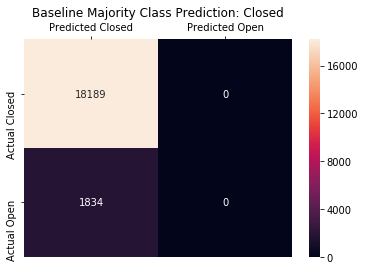

In [15]:
# confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_table(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=columns, index=index)

  return table

def plot_confusion_matrix(y_true, y_pred, title):
  table = make_confusion_table(y_true, y_pred)
  ax = sns.heatmap(table, annot=True, fmt='d')
  ax.set_title(title)
  ax.xaxis.tick_top()
  return ax

plot_confusion_matrix(y_val, y_pred, f'Baseline Majority Class Prediction: {majority_class}');

In [16]:
# precision / recall 1

predicted_closed = 18189 + 1834
prdicted_open = 0 + 0
actual_closed = 18189 + 0
actual_open = 1834 + 0

correct_closed = 18189
correct_open = 0

total_correct = correct_closed + correct_open
total = actual_closed + actual_open

accuracy = total_correct / total

precision_closed = correct_closed / total
precision_open = correct_open / total

recall_closed = correct_closed / actual_closed
recall_open = correct_open / actual_open

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision Closed: {precision_closed * 100:.2f}%')  # precision = correct_predictions / len_predictions
print(f'Precision Open: {precision_open * 100:.2f}%')  # precision = correct_predictions / len_predictions
print(f'Recall Closed: {recall_closed * 100:.2f}%')
print(f'Recall Open: {recall_open * 100:.2f}%')


Accuracy: 90.84%
Precision Closed: 90.84%
Precision Open: 0.00%
Recall Closed: 100.00%
Recall Open: 0.00%


In [17]:
# precision / recall 2

from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Closed       0.91      1.00      0.95     18189
        Open       0.00      0.00      0.00      1834

    accuracy                           0.91     20023
   macro avg       0.45      0.50      0.48     20023
weighted avg       0.83      0.91      0.86     20023



In [31]:
from sklearn.metrics import roc_auc_score

y_pred_proba = [y_train.value_counts(normalize=True)[0]] * len(y_pred)

print(f'ROC/AUC: {roc_auc_score(y_val, y_pred_proba) * 100:.2f}%')

ROC/AUC: 50.00%


### define Evaluation Metrics functions

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.utils.multiclass import unique_labels
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning, module='sklearn')

def make_confusion_table(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=columns, index=index)

  return table

def plot_confusion_matrix(y_true, y_pred, title=''):
  table = make_confusion_table(y_true, y_pred)
  ax = sns.heatmap(table, annot=True, fmt='d')
  ax.set_title(title)
  ax.xaxis.tick_top()
  return ax
  
def evaluate(y_true, y_pred, title='', y_pred_proba=None):
  print(f'Accuracy score: {accuracy_score(y_true, y_pred) * 100:.2f}%')
  if not y_pred_proba is None:
    print(f'ROC/AUC score: {roc_auc_score(y_true, y_pred_proba) * 100:.2f}%')
  print()
  print(classification_report(y_true, y_pred))
  print()
  display(make_confusion_table(y_true, y_pred))
  print()
  return plot_confusion_matrix(y_true, y_pred, title)

Accuracy score: 90.84%

              precision    recall  f1-score   support

      Closed       0.91      1.00      0.95     18189
        Open       0.00      0.00      0.00      1834

    accuracy                           0.91     20023
   macro avg       0.45      0.50      0.48     20023
weighted avg       0.83      0.91      0.86     20023




,Predicted Closed,Predicted Open
Actual Closed,18189,0
Actual Open,1834,0


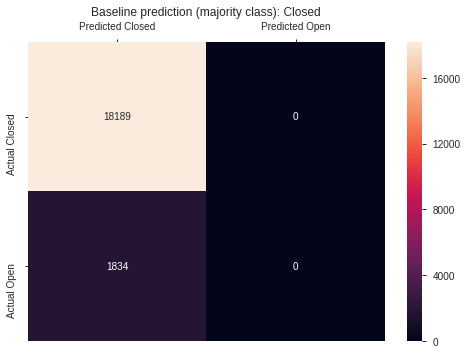

In [59]:
evaluate(y_val, y_pred, f'Baseline prediction (majority class): {majority_class}');

## Continue to explore the data

In [0]:
#@title helper functions

def explore(column):
  print(column)
  print()
  print(column.describe())
  print()
  print(f'Nulls: {column.isnull().sum()}')
  if pd.api.types.is_numeric_dtype(column.dtype):
    print(f'Unique: {column.nunique()}')
    print(f'Mode: {column.mode()}')
  print()
  print(column.value_counts())
  print()
  print(column.unique()[:min(100, column.nunique())])
  if(column.nunique() >= 100):
    print(' ...')

datetime_to_fiscal_year = lambda dt : dt.year if dt.month < 10 else dt.year + 1

### Days Open

In [41]:
train.corr()

,Days Opened,Days to Process
Days Opened,1.000000,0.940005
Days to Process,0.940005,1.000000


In [42]:
train['Days Opened'].isnull().sum()

29929

In [43]:
train['Days to Process'].isnull().sum()

76015

dropping days to process because it has high correlation to days opened and has more nulls than days opened

### wrangle function

In [0]:
def wrangle(dataframe):
  df = dataframe.copy()

  if target in df.columns:
    df.drop([target], axis=1, inplace=True)

  assert df['Request #'].nunique() == len(df['Request #']), '"Request #" contains non-unique values'
  df.set_index('Request #', inplace=True)

  df['Initial Request Type'] = df['Initial Request Type'].str.replace('^([A-Z]+|Initial) ', '')
  df['Initial Request Type'] = df['Initial Request Type'].str.replace('FOIA/PA', 'Privacy Act')
  df['Initial Request Type'] = df['Initial Request Type'].str.replace('Request', 'Consult')
  df['Initial Request Type'] = df['Initial Request Type'].str.replace('ation$', '')
  assert df['Initial Request Type'].nunique() == 3, 'Dirty data in "Initial Request Type"'

  df['Track Type'] = df['Track Type'].str.replace('Expedited', 'Expedite')
  df['Track Type'] = df['Track Type'].str.replace('SImple', 'Simple')
  assert df['Track Type'].nunique() == 3, 'Dirty data in "Track Type"'

  df['Initial Received Date'] = pd.to_datetime(df['Initial Received Date'], infer_datetime_format=True, errors='coerce')
  assert df['Initial Received Date'].isnull().sum() == 0, '"Initial Received Dates" contains null values'
  df['Fiscal Year Received'] = df['Initial Received Date'].transform(lambda dt : dt.year if dt.month < 10 else dt.year + 1)
  df['Backlogged Request'] = df['Fiscal Year Received'] < 2018
  df['Month Received'] = df['Initial Received Date'].dt.month
  df['Month Received Name'] = df['Initial Received Date'].dt.month_name()
  df.drop(['Initial Received Date'], axis=1, inplace=True)

  df['Perfected'] = pd.to_datetime(df['Perfected'], infer_datetime_format=True, errors='coerce')
  df['Perfected is NULL'] = df['Perfected'].isnull()
  df['Fiscal Year Perfected'] = df['Perfected'].transform(lambda dt : dt.year if dt.month < 10 else dt.year + 1)
  df.drop(['Perfected'], axis=1, inplace=True)

  df.drop(['Closed Date'], axis=1, inplace=True)

  df.drop(['Days to Process'], axis=1, inplace=True)

  return df

In [48]:
df_train, df_val, df_test = map(wrangle, [train, val, test])
df_train.shape, df_val.shape, df_test.shape

((80091, 13), (20023, 13), (25029, 13))

In [25]:
import pandas_profiling

df_train.profile_report()

## Model

In [66]:
df_train.head()

,Agency,Initial Request Type,Track Type,Days Opened,Disposition,"Disposition ""Other"" Reason",Exemptions Used,Fiscal Year Received,Backlogged Request,Month Received,Month Received Name,Perfected is NULL,Fiscal Year Perfected
Request #,,,,,,,,,,,,,
2018-ICFO-39132,ICE,FOIA,Simple,2.0,Granted/Denied in Part,NaN,"(b)(6),(b)(7)(C),(b)(7)(E)",2018,False,5,May,True,NaN
2018-OBFO-12588,CISA,FOIA,Complex,NaN,Granted/Denied in Part,"(b)(6),(b)(7)(C),(b)(7)(E),(b)(3):8 U.S.C. 12...",NaN,2018,False,1,January,True,NaN
2018-IGFO-00162,OIG,FOIA,Simple,NaN,Denied in Full,(b)(7)(A),NaN,2018,False,7,July,True,NaN
2018-ICFO-49654,ICE,FOIA,Simple,13.0,Granted/Denied in Part,NaN,"(b)(6),(b)(7)(C),(b)(7)(E),Duplicate",2018,False,7,July,True,NaN
2018-ICFO-44699,ICE,FOIA,Simple,22.0,Granted/Denied in Part,NaN,"(b)(5),(b)(6),(b)(7)(C),(b)(7)(E),(b)(3):49 U....",2018,False,6,June,True,NaN


In [0]:
features = ['Initial Request Type', 'Track Type', 'Agency', 'Fiscal Year Received', 'Backlogged Request', 'Month Received', 'Perfected is NULL']

X_train = df_train[features]
X_val = df_val[features]

Accuracy score: 92.12%
ROC/AUC score: 89.63%

              precision    recall  f1-score   support

      Closed       0.92      0.99      0.96     18189
        Open       0.79      0.19      0.31      1834

    accuracy                           0.92     20023
   macro avg       0.86      0.59      0.63     20023
weighted avg       0.91      0.92      0.90     20023




,Predicted Closed,Predicted Open
Actual Closed,18093,96
Actual Open,1482,352


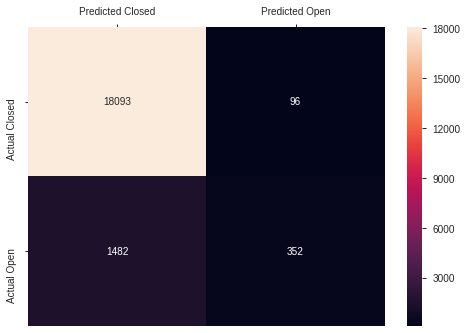

In [67]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier

encoder = ce.OrdinalEncoder()
model = RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_leaf=10, random_state=random_state, bootstrap=False)

X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val)

model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_val_encoded)
y_pred_proba = model.predict_proba(X_val_encoded)

evaluate(y_val, y_pred, y_pred_proba=y_pred_proba[:,1]);

## Today's assignment

In [69]:
X_val_encoded.head()

,Initial Request Type,Track Type,Agency,Fiscal Year Received,Backlogged Request,Month Received,Perfected is NULL
Request #,,,,,,,
2018-OBFO-13877,1,2,2,2018,False,2,True
2018-ICFO-55542,1,1,1,2018,False,8,True
2018-OBFO-22835,1,2,2,2018,False,5,True
2018-ICFO-13776,1,1,1,2018,False,1,True
2018-ICFO-47286,1,1,1,2018,False,7,True


In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

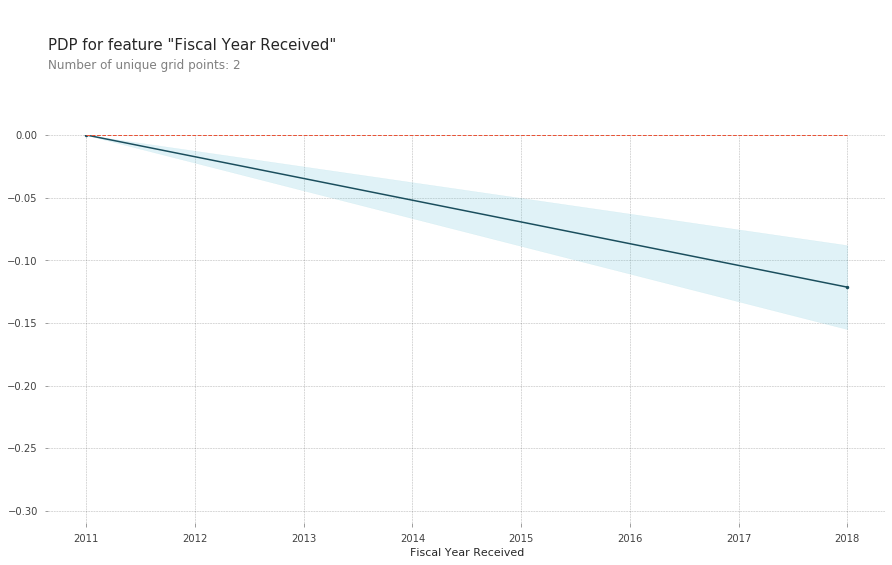

In [77]:
feature = 'Fiscal Year Received'

isolated = pdp_isolate(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    feature=feature
)

pdp_plot(isolated, feature);

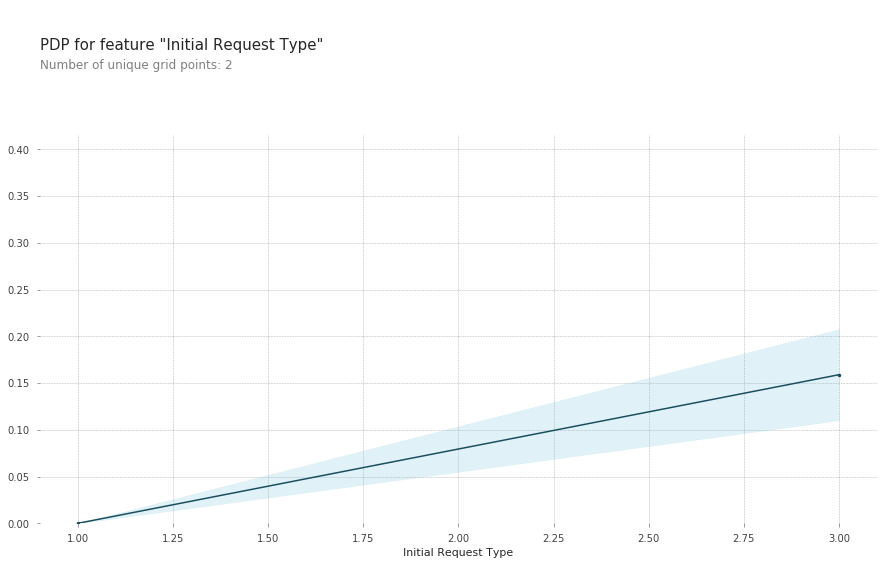

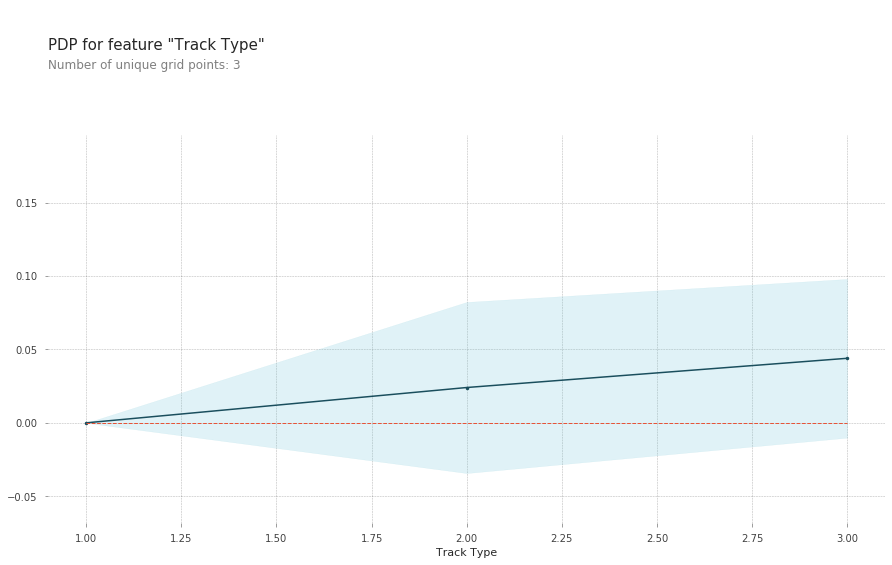

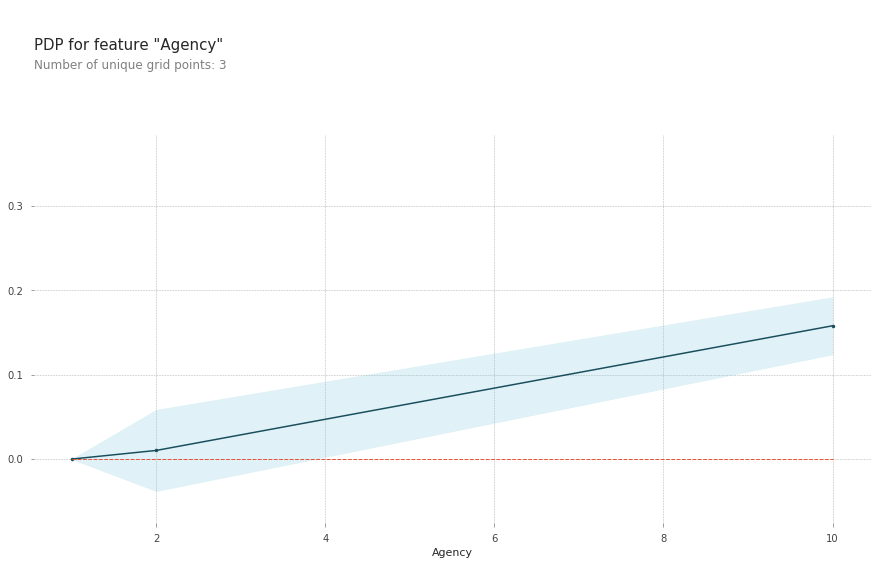

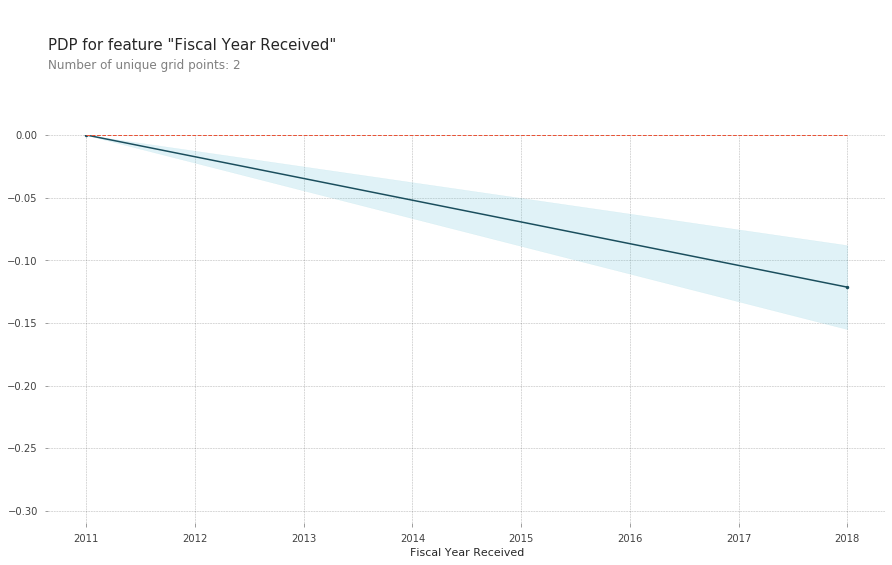

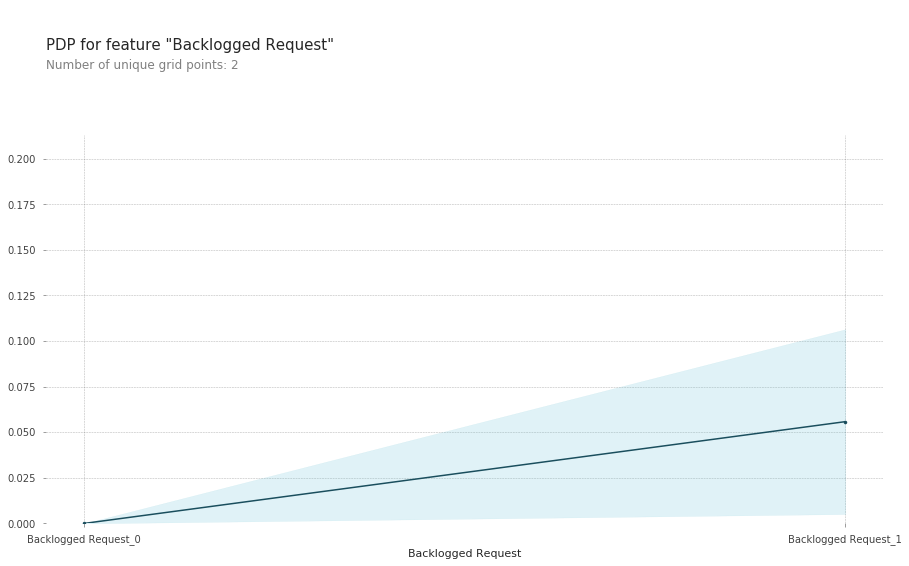

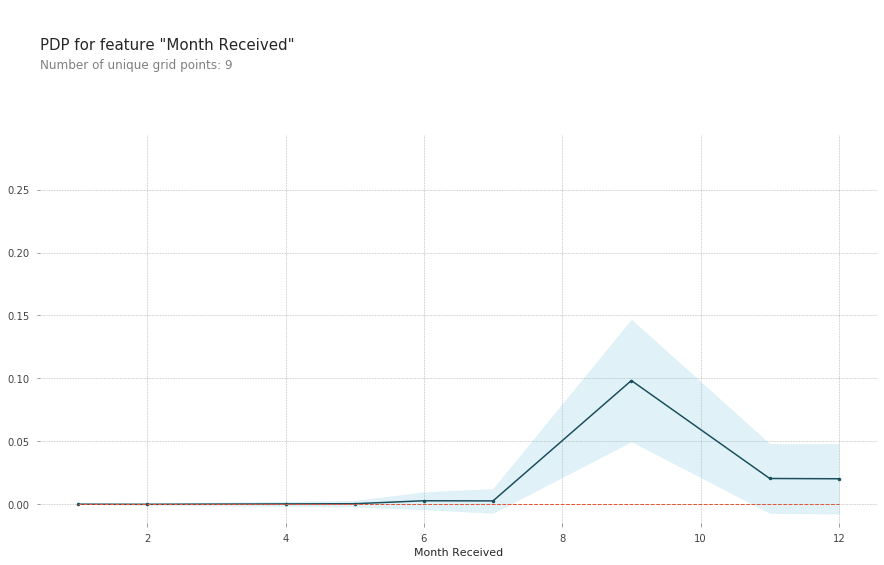

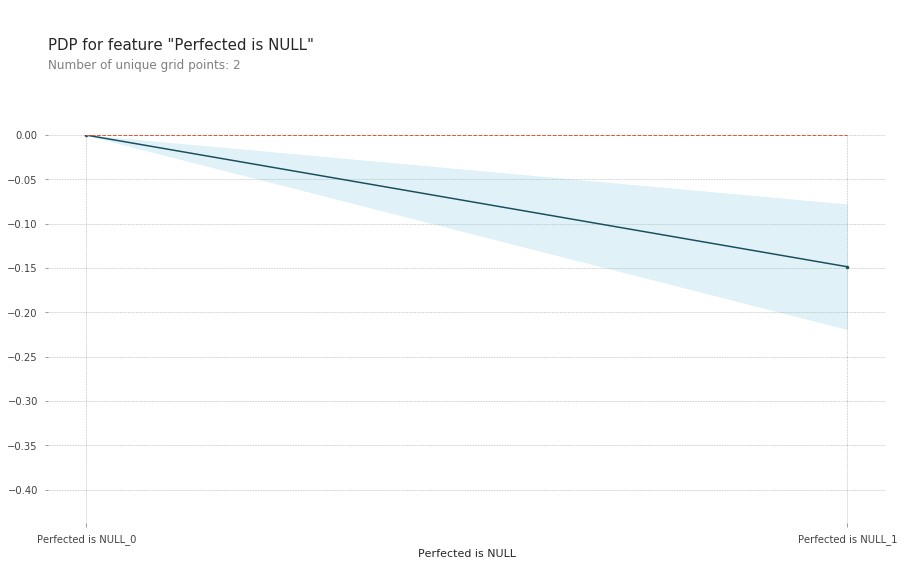

In [73]:
for feature in X_val_encoded.columns:
  isolated = pdp_isolate(model, X_val_encoded, X_val_encoded.columns, feature, n_jobs=-1)
  pdp_plot(isolated, feature)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


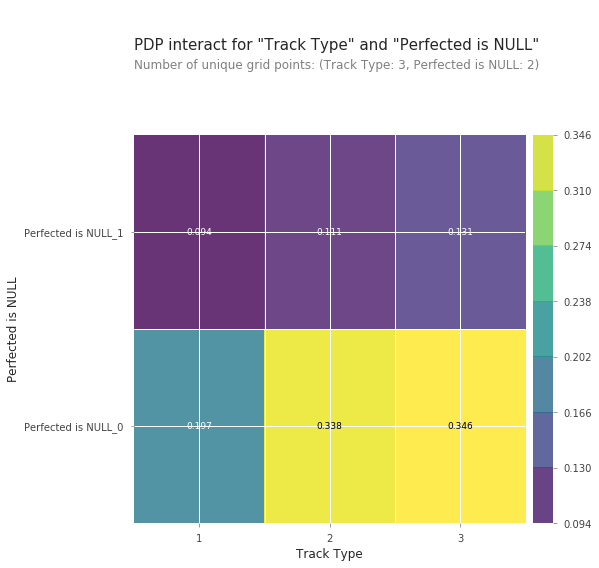

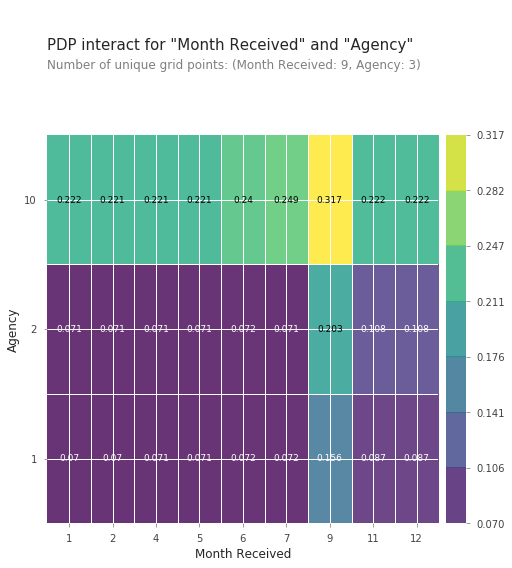

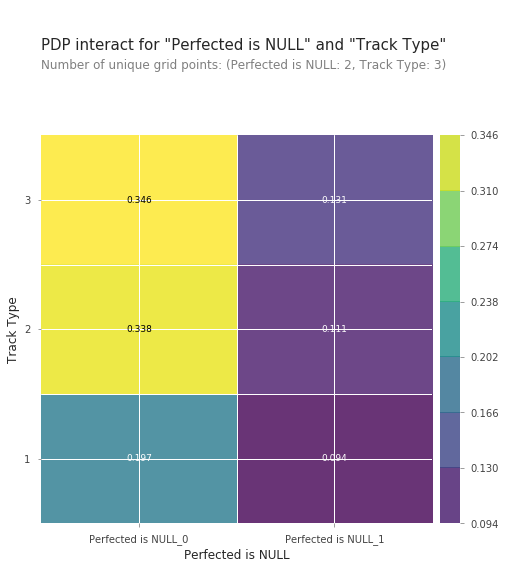

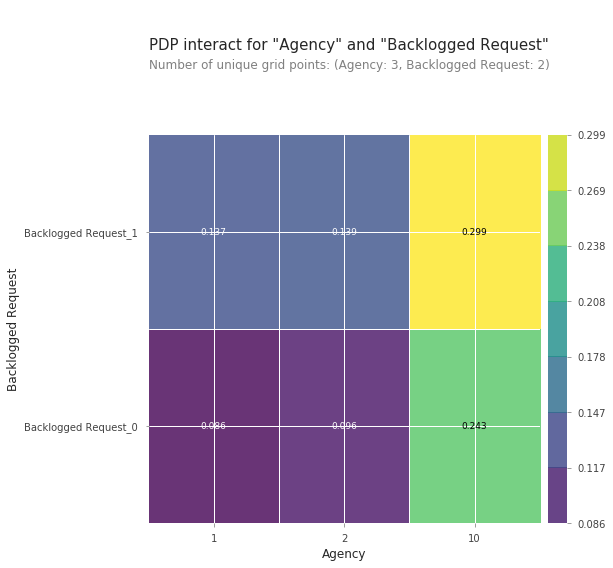

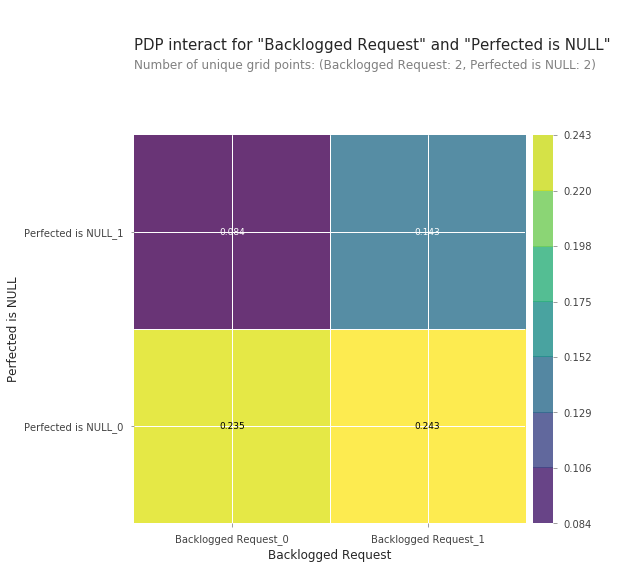

In [78]:
import random

for i in range(5):
  interact_features = random.choices(X_val_encoded.columns, k=2)
  interaction = pdp_interact(model, X_val_encoded, X_val_encoded.columns, features=interact_features)
  pdp_interact_plot(interaction, interact_features, plot_type='grid')

In [0]:
import shap

In [83]:
explainer = shap.TreeExplainer(model)

row = X_val_encoded.iloc[[0]]

row

,Initial Request Type,Track Type,Agency,Fiscal Year Received,Backlogged Request,Month Received,Perfected is NULL
Request #,,,,,,,
2018-OBFO-13877,1,2,2,2018,False,2,True


In [84]:
model.predict(row)

array(['Closed'], dtype=object)

In [87]:
shap_values = explainer.shap_values(row)
shap_values

[array([[0.00232214, 0.00602606, 0.0216628 , 0.00345031, 0.00333275,
         0.02106659, 0.01233871]]),
 array([[-0.00232214, -0.00602606, -0.0216628 , -0.00345031, -0.00333275,
         -0.02106659, -0.01233871]])]

In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, row)